# Basic training of YOLO v11 detection model

**Libraries installation and import**

In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [2]:
from google.colab.patches import cv2_imshow
from PIL import ImageFont, ImageDraw, Image
from ultralytics import YOLO
from pathlib import Path
import numpy as np
import kagglehub
import shutil
import random
import yaml
import cv2
import os

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


---

**Dataset download**

In [7]:
# download dataset from kaggle
path = kagglehub.dataset_download("nguyngiabol/colorful-fashion-dataset-for-object-detection")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/colorful-fashion-dataset-for-object-detection


In [8]:
# create directories for dataset store
base_dir = Path("/content/colorful_object_detection/")
image_dir = base_dir / "images"
label_dir = base_dir / "labels"

for folder in [image_dir, label_dir]:
  folder.mkdir(parents=True, exist_ok=True)

In [9]:
# copy data to the current directory 'colorful_object_detection'
source_root = Path('/kaggle/input/colorful-fashion-dataset-for-object-detection/colorful_fashion_dataset_for_object_detection/')
source_imgs = source_root / 'JPEGImages'
source_annots = source_root / 'Annotations_txt'
for img in source_imgs.glob('*'):
    shutil.copy(img, image_dir / img.name)
    annot = source_annots / f'{img.stem}.txt'
    shutil.copy(annot, label_dir / annot.name)
print("Copy is done")

Copy is done


In [10]:
# directories creation
for split in ['train', 'val']:
  (image_dir / split).mkdir(parents=True, exist_ok=True)
  (label_dir / split).mkdir(parents=True, exist_ok=True)

# files shuffle
files = list(image_dir.glob("*.jpg"))
np.random.shuffle(files)

# split on train/val
train_cnt = int(len(files) * 0.9)
train_files, val_files = files[:train_cnt], files[train_cnt:]

# move files to train/val directories
for index, img_path in enumerate(files):
    split = 'train' if index < train_cnt else 'val'

    dest_img = image_dir / split / img_path.name
    shutil.move(str(img_path), str(dest_img))

    txt_path = label_dir / (img_path.stem + '.txt')
    dest_txt = label_dir / split / txt_path.name
    shutil.move(str(txt_path), str(dest_txt))

---

**Data Overview**

Shape of the image: (600, 400, 3)


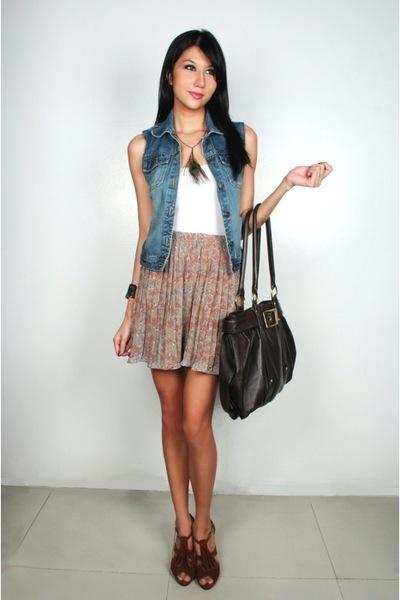

In [11]:
img = cv2.imread(str(image_dir / 'train' / '100599.jpg'))
print(f"Shape of the image: {img.shape}")
cv2_imshow(img)

In [12]:
labels = []
with open(label_dir / 'train' / '100599.txt') as f:
    labels = [line.strip() for line in f if line.strip()]
print("Clothes' bounding boxes in an image:")
for label in labels:
    cls, xmin, ymin, xmax, ymax = label.split()
    print(f"Class {cls}, xmin: {xmin}, ymin: {ymin}, xmax: {xmax}, ymax: {ymax}")

Clothes' bounding boxes in an image:
Class 3, xmin: 0.482500, ymin: 0.325833, xmax: 0.270000, ymax: 0.285000
Class 8, xmin: 0.631250, ymin: 0.519167, xmax: 0.212500, ymax: 0.358333
Class 3, xmin: 0.496250, ymin: 0.320000, xmax: 0.127500, ymax: 0.146667
Class 9, xmin: 0.483750, ymin: 0.937500, xmax: 0.122500, ymax: 0.075000
Class 6, xmin: 0.470000, ymin: 0.510000, xmax: 0.315000, ymax: 0.250000


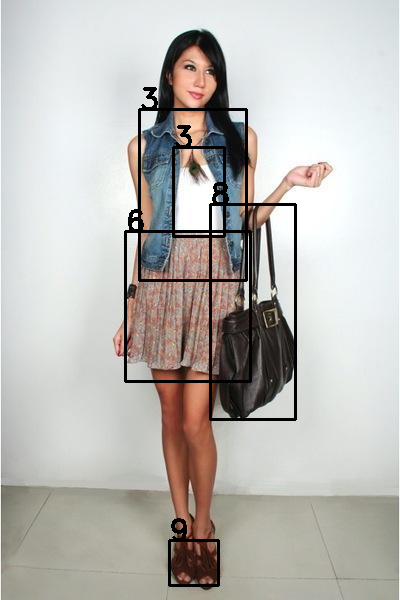

In [13]:
def get_annotation(img, labels):
  img_height, img_width, img_channels = img.shape
  for obj in labels:
    name, x, y, width, height = obj.split(" ")
    x, y, width, height = map(float, [x, y, width, height])
    x1_real = int(np.abs(x - (width/2)) * img_width)
    x2_real = int(np.abs(x + (width/2)) * img_width)
    y1_real = int(np.abs(y + (height/2)) * img_height)
    y2_real = int(np.abs(y - (height/2)) * img_height)
    color = (0, 0, 0)
    image = cv2.rectangle(img, (x1_real, y2_real), (x2_real, y1_real), color = color, thickness = 2)
    image = cv2.putText(img, name, (x1_real, y2_real), fontFace=cv2.FONT_HERSHEY_DUPLEX,
                      fontScale=1.0, color=color, thickness=2)
  return img

img = get_annotation(img, labels)
cv2_imshow(img)

---

**Compose metadata about dataset in yaml file**

In [20]:
data = {
    'nc': 10,
    'train': 'colorful_object_detection/images/train',
    'val': 'colorful_object_detection/images/val',
    'names': {
        0: 'sunglass',
        1: 'hat',
        2: 'jacket',
        3: 'shirt',
        4: 'pants',
        5: 'shorts',
        6: 'skirt',
        7: 'dress',
        8: 'bag',
        9: 'shoe'
    }
}

with open('data.yaml', 'w') as file:
  yaml.dump(data, file)

---

**YOLO v11 Model Fine-Tuning**

In [23]:
model = YOLO("yolo11m.pt")

results = model.train(
    data='data.yaml',
    epochs=100,
    batch=64,
    device=[0],
    freeze=8,
    lr0=3e-4,
    augment=True,
    lrf=0.1
)

Ultralytics 8.3.159 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=8, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0003, lrf=0.1, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False, p

train: Scanning /content/colorful_object_detection/labels/train.cache... 2413 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2413/2413 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 353.2±95.4 MB/s, size: 42.4 KB)


val: Scanning /content/colorful_object_detection/labels/val.cache... 269 images, 0 backgrounds, 0 corrupt: 100%|██████████| 269/269 [00:00<?, ?it/s]


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0003' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train4
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      14.4G      1.395      2.371      1.526        329        640: 100%|██████████| 38/38 [00:54<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

                   all        269       1016      0.611      0.636      0.626      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      13.3G      1.243      1.183      1.339        346        640: 100%|██████████| 38/38 [00:56<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


                   all        269       1016      0.347      0.546      0.441      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      13.4G       1.26       1.14      1.358        350        640: 100%|██████████| 38/38 [00:55<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


                   all        269       1016        0.3      0.315      0.214      0.107

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      13.3G      1.254      1.105      1.359        371        640: 100%|██████████| 38/38 [00:55<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


                   all        269       1016      0.596      0.488      0.501      0.286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      13.2G      1.236      1.052      1.338        335        640: 100%|██████████| 38/38 [00:55<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


                   all        269       1016      0.702       0.58      0.649       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      14.4G      1.211      1.011      1.328        363        640: 100%|██████████| 38/38 [00:55<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

                   all        269       1016      0.743      0.687      0.733      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      14.4G      1.181     0.9483      1.312        330        640: 100%|██████████| 38/38 [00:55<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


                   all        269       1016      0.737      0.651      0.745      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      14.4G      1.158     0.9161       1.29        377        640: 100%|██████████| 38/38 [00:55<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


                   all        269       1016      0.731      0.735      0.759       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      14.4G      1.149     0.9066      1.285        364        640: 100%|██████████| 38/38 [00:55<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


                   all        269       1016      0.721        0.7      0.759      0.475

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      14.4G      1.121      0.875      1.266        381        640: 100%|██████████| 38/38 [00:55<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

                   all        269       1016      0.813      0.712      0.775      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      14.4G      1.106     0.8431      1.259        333        640: 100%|██████████| 38/38 [00:55<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

                   all        269       1016      0.727       0.76      0.774      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      14.4G      1.103     0.8496       1.25        392        640: 100%|██████████| 38/38 [00:55<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

                   all        269       1016      0.783      0.741      0.765      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      14.4G      1.088     0.8208      1.247        395        640: 100%|██████████| 38/38 [00:55<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]

                   all        269       1016      0.766      0.756      0.768      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      13.2G      1.079     0.7998      1.242        306        640: 100%|██████████| 38/38 [00:55<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

                   all        269       1016      0.756      0.753      0.787      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      14.4G      1.061     0.7843      1.227        361        640: 100%|██████████| 38/38 [00:55<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

                   all        269       1016      0.752      0.725      0.771      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      14.4G      1.062     0.7775      1.227        321        640: 100%|██████████| 38/38 [00:55<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

                   all        269       1016      0.742      0.767      0.786      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      13.3G      1.042      0.766      1.219        302        640: 100%|██████████| 38/38 [00:55<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

                   all        269       1016      0.759      0.761      0.795      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      13.3G      1.036     0.7477      1.215        344        640: 100%|██████████| 38/38 [00:55<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]

                   all        269       1016      0.782      0.745      0.781       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      14.4G      1.025     0.7322      1.207        334        640: 100%|██████████| 38/38 [00:55<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

                   all        269       1016      0.745      0.775      0.791      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      14.4G      1.002      0.713      1.194        378        640: 100%|██████████| 38/38 [00:55<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

                   all        269       1016      0.798       0.74      0.784      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      14.4G     0.9981     0.6918      1.178        376        640: 100%|██████████| 38/38 [00:55<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

                   all        269       1016      0.751      0.721      0.767      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      14.4G     0.9946     0.7004      1.188        280        640: 100%|██████████| 38/38 [00:55<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

                   all        269       1016      0.773      0.758      0.789      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      14.4G      0.983     0.6904       1.18        327        640: 100%|██████████| 38/38 [00:55<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

                   all        269       1016       0.82      0.736      0.799      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      14.4G     0.9751     0.6703       1.17        318        640: 100%|██████████| 38/38 [00:55<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

                   all        269       1016      0.797      0.742      0.781      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      14.4G     0.9762     0.6797      1.171        341        640: 100%|██████████| 38/38 [00:55<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

                   all        269       1016      0.763      0.755       0.78      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      13.3G     0.9557     0.6591      1.163        332        640: 100%|██████████| 38/38 [00:55<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


                   all        269       1016      0.769      0.762      0.792      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      14.4G     0.9531     0.6509      1.159        316        640: 100%|██████████| 38/38 [00:55<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

                   all        269       1016      0.786      0.752      0.787      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      13.2G      0.949     0.6534      1.158        305        640: 100%|██████████| 38/38 [00:55<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]

                   all        269       1016      0.747      0.749      0.772      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      13.2G      0.927     0.6271      1.143        316        640: 100%|██████████| 38/38 [00:55<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

                   all        269       1016      0.773      0.768      0.801      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      14.4G     0.9173     0.6127      1.135        348        640: 100%|██████████| 38/38 [00:55<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

                   all        269       1016      0.798      0.739      0.793      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      13.2G      0.921     0.6172      1.137        317        640: 100%|██████████| 38/38 [00:55<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


                   all        269       1016      0.771       0.75      0.789       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      14.4G      0.913     0.6097      1.136        361        640: 100%|██████████| 38/38 [00:55<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


                   all        269       1016      0.787      0.763      0.791       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      13.2G     0.8986      0.606      1.122        344        640: 100%|██████████| 38/38 [00:55<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

                   all        269       1016       0.72      0.766      0.791      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      13.2G     0.8996     0.5956       1.13        368        640: 100%|██████████| 38/38 [00:55<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

                   all        269       1016      0.777      0.752      0.774       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      13.2G     0.8879     0.5841      1.118        409        640: 100%|██████████| 38/38 [00:55<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]

                   all        269       1016      0.759      0.744      0.774      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      13.3G     0.8817     0.5827      1.113        341        640: 100%|██████████| 38/38 [00:55<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

                   all        269       1016      0.778       0.75      0.785      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      14.4G     0.8745     0.5715      1.108        333        640: 100%|██████████| 38/38 [00:55<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

                   all        269       1016      0.732      0.766      0.773       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      14.4G     0.8713     0.5715       1.11        348        640: 100%|██████████| 38/38 [00:55<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

                   all        269       1016      0.794       0.74      0.783      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      14.4G     0.8584     0.5561      1.098        356        640: 100%|██████████| 38/38 [00:55<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


                   all        269       1016      0.778      0.727      0.762      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      13.3G     0.8601     0.5593      1.096        277        640: 100%|██████████| 38/38 [00:55<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


                   all        269       1016      0.793      0.748      0.784      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      14.4G     0.8574     0.5588        1.1        314        640: 100%|██████████| 38/38 [00:55<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

                   all        269       1016      0.752      0.758      0.775        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      14.4G     0.8406     0.5496      1.084        356        640: 100%|██████████| 38/38 [00:55<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

                   all        269       1016      0.725      0.773      0.766      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      14.4G     0.8342     0.5345      1.079        311        640: 100%|██████████| 38/38 [00:55<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

                   all        269       1016      0.803      0.717      0.772      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      14.4G     0.8334      0.543      1.082        349        640: 100%|██████████| 38/38 [00:55<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

                   all        269       1016      0.707      0.797      0.775       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      13.2G     0.8293     0.5399      1.079        292        640: 100%|██████████| 38/38 [00:55<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

                   all        269       1016       0.81      0.737      0.772      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      13.2G     0.8128      0.519       1.07        324        640: 100%|██████████| 38/38 [00:55<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        269       1016      0.741      0.762      0.772      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      14.4G     0.8191      0.522      1.074        357        640: 100%|██████████| 38/38 [00:55<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

                   all        269       1016      0.732      0.773       0.78       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      14.4G     0.8132     0.5213      1.071        375        640: 100%|██████████| 38/38 [00:55<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

                   all        269       1016      0.806      0.757      0.792      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      14.4G     0.7997      0.512      1.063        331        640: 100%|██████████| 38/38 [00:55<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

                   all        269       1016      0.781      0.755      0.784      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      14.4G     0.7937     0.5043      1.062        323        640: 100%|██████████| 38/38 [00:55<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

                   all        269       1016      0.746      0.768      0.779      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      14.4G     0.7893     0.5063      1.059        329        640: 100%|██████████| 38/38 [00:55<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

                   all        269       1016      0.754       0.76      0.789      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      14.4G     0.7811      0.501      1.055        304        640: 100%|██████████| 38/38 [00:55<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

                   all        269       1016      0.768       0.78      0.787      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      13.2G     0.7707      0.489      1.051        387        640: 100%|██████████| 38/38 [00:55<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

                   all        269       1016      0.705      0.795      0.771      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      14.4G     0.7723     0.4917      1.047        323        640: 100%|██████████| 38/38 [00:55<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

                   all        269       1016      0.773      0.738       0.76      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      14.4G     0.7629     0.4891       1.04        325        640: 100%|██████████| 38/38 [00:55<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

                   all        269       1016      0.754      0.773      0.779      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      14.4G     0.7629     0.4915      1.045        391        640: 100%|██████████| 38/38 [00:55<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


                   all        269       1016      0.771      0.757      0.777      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      13.2G     0.7604     0.4828      1.039        313        640: 100%|██████████| 38/38 [00:55<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]

                   all        269       1016      0.774      0.762      0.784      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      14.4G     0.7574     0.4823      1.037        377        640: 100%|██████████| 38/38 [00:55<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        269       1016      0.813      0.742      0.785      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      13.3G     0.7434     0.4759      1.032        452        640: 100%|██████████| 38/38 [00:55<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

                   all        269       1016      0.776      0.736      0.775       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      14.4G     0.7465     0.4707      1.027        330        640: 100%|██████████| 38/38 [00:55<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

                   all        269       1016      0.823      0.748      0.777      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      14.4G     0.7414     0.4691      1.027        293        640: 100%|██████████| 38/38 [00:55<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]

                   all        269       1016      0.761      0.769      0.782      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      14.4G     0.7306     0.4625      1.023        365        640: 100%|██████████| 38/38 [00:55<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

                   all        269       1016      0.759       0.77      0.768      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      14.4G     0.7353      0.463      1.027        362        640: 100%|██████████| 38/38 [00:54<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

                   all        269       1016      0.773      0.748      0.772      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      14.4G     0.7205     0.4511      1.022        283        640: 100%|██████████| 38/38 [00:55<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

                   all        269       1016      0.728      0.789      0.786      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      14.4G     0.7207     0.4602      1.021        366        640: 100%|██████████| 38/38 [00:55<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

                   all        269       1016      0.764      0.765      0.773      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      14.4G     0.7213     0.4498      1.019        316        640: 100%|██████████| 38/38 [00:55<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


                   all        269       1016      0.744      0.795      0.778      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      13.2G     0.7112     0.4429      1.012        330        640: 100%|██████████| 38/38 [00:55<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

                   all        269       1016      0.779      0.756      0.774      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      14.4G     0.7135      0.446      1.013        328        640: 100%|██████████| 38/38 [00:55<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

                   all        269       1016      0.789      0.762      0.776      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      14.4G     0.6984     0.4357      1.004        335        640: 100%|██████████| 38/38 [00:55<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

                   all        269       1016      0.806       0.74      0.782      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      13.2G     0.6943     0.4362      1.007        364        640: 100%|██████████| 38/38 [00:55<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]

                   all        269       1016      0.778      0.783      0.794      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      14.4G     0.7012     0.4369      1.005        322        640: 100%|██████████| 38/38 [00:55<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]

                   all        269       1016      0.774      0.769      0.785      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      14.4G     0.6902     0.4315          1        323        640: 100%|██████████| 38/38 [00:54<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]

                   all        269       1016      0.728      0.764      0.771      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      13.4G     0.6882     0.4258     0.9984        307        640: 100%|██████████| 38/38 [00:54<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

                   all        269       1016      0.773      0.752      0.778      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      14.4G     0.6835     0.4293     0.9961        365        640: 100%|██████████| 38/38 [00:55<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]

                   all        269       1016      0.772      0.768      0.782      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      14.4G     0.6816     0.4214     0.9983        341        640: 100%|██████████| 38/38 [00:54<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

                   all        269       1016      0.791      0.752      0.775      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      14.4G     0.6813     0.4271     0.9948        307        640: 100%|██████████| 38/38 [00:55<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

                   all        269       1016      0.793      0.742      0.782       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      14.4G     0.6733     0.4174     0.9877        300        640: 100%|██████████| 38/38 [00:55<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

                   all        269       1016       0.81      0.767      0.789      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      14.4G      0.666     0.4186     0.9867        324        640: 100%|██████████| 38/38 [00:55<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

                   all        269       1016      0.777      0.759      0.774      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      13.3G     0.6644     0.4176     0.9937        332        640: 100%|██████████| 38/38 [00:55<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

                   all        269       1016      0.744      0.774      0.765      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      14.4G       0.66     0.4136      0.985        290        640: 100%|██████████| 38/38 [00:55<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

                   all        269       1016      0.762      0.784       0.78      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      13.2G     0.6577     0.4118      0.981        361        640: 100%|██████████| 38/38 [00:55<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

                   all        269       1016        0.8      0.754      0.784      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      13.2G     0.6571     0.4066     0.9817        393        640: 100%|██████████| 38/38 [00:55<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]

                   all        269       1016      0.769      0.765      0.772       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      14.4G     0.6454     0.4025     0.9753        324        640: 100%|██████████| 38/38 [00:55<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

                   all        269       1016      0.789       0.77      0.781       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      14.4G     0.6458     0.3997     0.9765        356        640: 100%|██████████| 38/38 [00:55<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

                   all        269       1016      0.792      0.768      0.781      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      14.4G     0.6463     0.3992     0.9789        308        640: 100%|██████████| 38/38 [00:55<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

                   all        269       1016      0.781      0.758      0.774      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      14.4G     0.6433     0.4015      0.971        376        640: 100%|██████████| 38/38 [00:55<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

                   all        269       1016      0.804      0.748      0.774      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      13.2G     0.6327     0.3938     0.9683        344        640: 100%|██████████| 38/38 [00:55<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

                   all        269       1016      0.784      0.761      0.781       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      13.2G     0.6299       0.39     0.9687        342        640: 100%|██████████| 38/38 [00:55<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        269       1016      0.785      0.791      0.785      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      14.4G      0.629     0.3886     0.9693        345        640: 100%|██████████| 38/38 [00:55<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

                   all        269       1016      0.796      0.776      0.785      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      14.4G     0.6252     0.3913     0.9686        293        640: 100%|██████████| 38/38 [00:55<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

                   all        269       1016      0.789       0.78      0.781      0.532


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      14.4G     0.5416     0.2974     0.9122        172        640: 100%|██████████| 38/38 [00:57<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

                   all        269       1016      0.799      0.757      0.774      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      14.4G     0.5421      0.294     0.9123        170        640: 100%|██████████| 38/38 [00:54<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

                   all        269       1016      0.793      0.779      0.783       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      14.4G     0.5337     0.2926     0.9057        166        640: 100%|██████████| 38/38 [00:54<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

                   all        269       1016        0.8      0.746      0.774      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      14.4G     0.5299     0.2924     0.9059        162        640: 100%|██████████| 38/38 [00:54<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

                   all        269       1016      0.799      0.752      0.776      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      14.4G     0.5289     0.2877     0.9074        176        640: 100%|██████████| 38/38 [00:54<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

                   all        269       1016      0.778      0.765      0.783      0.533



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b7f74078cc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b7f74078cc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/38 [00:00<?, ?it/s]  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
     96/100      14.4G     0.5297     0.2904     0.9051        151        640: 100%|██████████| 38/38 [00:54<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b7f74078cc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.

                   all        269       1016      0.802      0.762      0.782      0.534

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      14.4G     0.5176     0.2804     0.9029        165        640: 100%|██████████| 38/38 [00:54<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

                   all        269       1016      0.768      0.774      0.776      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      14.4G     0.5095      0.279     0.8967        163        640: 100%|██████████| 38/38 [00:54<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

                   all        269       1016      0.788       0.77      0.777      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      14.4G     0.5123     0.2796     0.8945        160        640: 100%|██████████| 38/38 [00:54<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

                   all        269       1016      0.798       0.76      0.773      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      14.4G      0.504     0.2734     0.8927        157        640: 100%|██████████| 38/38 [00:54<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]


                   all        269       1016      0.789      0.763      0.778      0.531

100 epochs completed in 1.671 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 40.5MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 40.5MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.159 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,037,742 parameters, 0 gradients, 67.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.34s/it]


                   all        269       1016      0.752      0.771      0.788      0.531
              sunglass         42         42      0.533      0.238        0.3      0.122
                   hat         31         31      0.896      0.832       0.91      0.572
                jacket         91         94      0.798      0.851      0.864      0.673
                 shirt        180        182       0.76      0.879      0.838      0.592
                 pants         64         64      0.842      0.919      0.941      0.715
                shorts         54         54      0.696      0.796      0.716      0.426
                 skirt         87         87      0.692      0.862      0.815      0.629
                 dress         71         71      0.771      0.831      0.848      0.635
                   bag        129        129      0.717      0.736      0.815      0.461
                  shoe        262        262      0.817      0.767      0.831      0.488
Speed: 0.1ms preproce